In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
from google.colab import files
import tensorflow as tf
from skimage.transform import radon, iradon
from scipy import ndimage
from tensorflow.keras.optimizers import Adam

print('tensorflow version: ' + tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


tensorflow version: 2.2.0-rc3


## Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# import labels
labels_df = pd.read_csv('/content/drive/My Drive/MLProject/ctlabels.csv')
labels = np.array(labels_df[' hemorrhage'].tolist())

# import preprocessed sinogram
x_all = np.load('/content/drive/My Drive/MLProject/all180.npy')

In [4]:
#expand labels according to images augmentation
labels_aug = []
for i in range(len(labels)):
    for j in range(12):
        labels_aug.append(labels[i])
y_all = np.uint8(np.array(labels_aug))
print(y_all.shape)
print((y_all == 0).sum())

(2400,)
1200


0


Text(0.5, 1.0, 'Reconstructed brain CT image from sinogram')

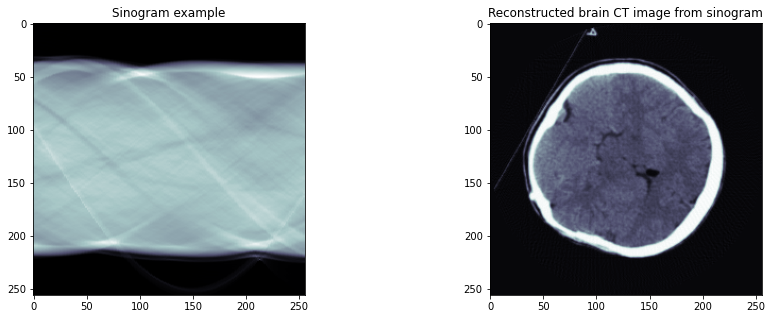

In [5]:
# Random shuffle training dataset and testing dataset
x_shuffle = np.zeros(x_all.shape)
y_shuffle = np.zeros(y_all.shape, dtype=np.uint8)
num = 12
order = np.arange(x_all.shape[0]/num)
np.random.shuffle(order)
for i, index in enumerate(order):
    x_shuffle[int(num*i):int(num*i+num), :, :] = x_all[int(num*index):int(num*index+num), :, :]
    y_shuffle[int(num*i):int(num*i+num)] = y_all[int(num*index):int(num*index+num)]

# Show the sinogram example and reconstructed brain CT image using the sinogram
fig = 2000
print(y_shuffle[fig])
f = plt.figure(figsize = (15,5))
f.add_subplot(1,2,1)
plt.imshow(x_shuffle[fig, :, :], cmap='bone')
plt.title('Sinogram example')

f.add_subplot(1,2,2)
rad =x_shuffle[fig]
back_rad, indices = np.unique(rad, axis=1, return_index=True)
back_rad = rad[:,np.sort(indices)]
plt.imshow(iradon(back_rad, circle=True), cmap='bone')
plt.title('Reconstructed brain CT image from sinogram')

In [6]:
# Train-test split
x_shuffle = x_shuffle/np.amax(x_shuffle)  #normalization
x_shuffle = x_shuffle[..., None]
y_shuffle = y_shuffle[..., None]
x_train = x_shuffle[:-240]
y_train = y_shuffle[:-240]
x_test = x_shuffle[-240:]
y_test = y_shuffle[-240:]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print((y_test == 0).sum())
N = 144
P = 240-144

(2160, 256, 256, 1) (2160, 1)
(240, 256, 256, 1) (240, 1)
120


## CNN Without Physical Layer

In [0]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256,256,1)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','FalsePositives','FalseNegatives'])

In [8]:
history_onlyCNN = cnn_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/100
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
68/68 [==============================] - 5s 77ms/step - loss: 0.7173 - accuracy: 0.6458 - false_positives: 374.0000 - false_negatives: 391.0000 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 2/100
68/68 [==============================] - 5s 67ms/step - loss: 0.6084 - accuracy: 0.6769 - false_positives: 361.0000 - false_negatives: 337.0000 - val_loss: 0.6869 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 3/100
68/68 [==============================] - 5s 67ms/step - loss: 0.5673 - accuracy: 0.7014 - false_positives: 324.0000 - false_negatives: 321.0000 - val_loss: 0.6958 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 4/100
68/68 [==============================] - 5s 67ms/step - loss: 0.5537 - accuracy: 0.7144 - false_positives: 297.0000

In [67]:
# Calculate sensitivity and specificity on validation data
print('False Positives in Validation: ' +str(history_onlyCNN.history['val_false_positives']))
print('False Negatives in Validation: ' +str(history_onlyCNN.history['val_false_negatives']))
FP_cnn = history_onlyCNN.history['val_false_positives']
FN_cnn = history_onlyCNN.history['val_false_negatives']

sensitivity_cnn = (P-np.mean(FN_cnn[10:]))/P
specificity_cnn = (N-np.mean(FP_cnn[10:]))/N

print(sensitivity_cnn)
print(specificity_cnn)

False Positives in Validation: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 12.0, 24.0, 16.0, 24.0, 24.0, 0.0, 14.0, 9.0, 17.0, 23.0, 25.0, 53.0, 26.0, 19.0, 21.0, 24.0, 0.0, 28.0, 16.0, 12.0, 16.0, 17.0, 32.0, 16.0, 11.0, 22.0, 9.0, 16.0, 9.0, 17.0, 10.0, 11.0, 12.0, 0.0, 11.0, 13.0, 3.0, 26.0, 9.0, 12.0, 24.0, 12.0, 12.0, 9.0, 4.0, 48.0, 13.0, 17.0, 1.0, 10.0, 8.0, 10.0, 0.0, 12.0, 17.0, 11.0, 12.0, 9.0, 31.0, 11.0, 15.0, 21.0, 15.0, 6.0, 9.0, 16.0, 11.0, 5.0, 11.0, 10.0, 8.0, 1.0, 12.0, 8.0, 10.0, 15.0, 17.0, 8.0, 19.0, 0.0, 0.0, 18.0, 10.0, 10.0, 8.0, 13.0, 11.0, 9.0, 19.0, 13.0, 1.0]
False Negatives in Validation: [120.0, 120.0, 120.0, 120.0, 113.0, 120.0, 113.0, 95.0, 74.0, 72.0, 61.0, 72.0, 55.0, 64.0, 72.0, 59.0, 65.0, 56.0, 26.0, 26.0, 9.0, 22.0, 34.0, 33.0, 24.0, 61.0, 21.0, 56.0, 55.0, 32.0, 24.0, 20.0, 27.0, 44.0, 22.0, 40.0, 32.0, 47.0, 20.0, 38.0, 35.0, 32.0, 61.0, 43.0, 25.0, 46.0, 12.0, 51.0, 32.0, 12.0, 29.0, 28.0, 42.0, 39.0, 9.0, 28.0, 20.0, 57.0, 35.0, 33.0, 31.0,

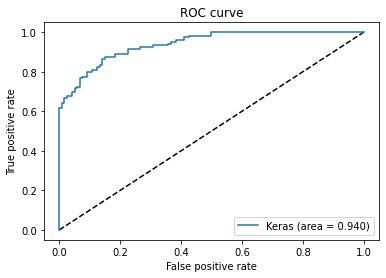

In [10]:
from sklearn.metrics import roc_curve

y_pred_keras = cnn_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [11]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

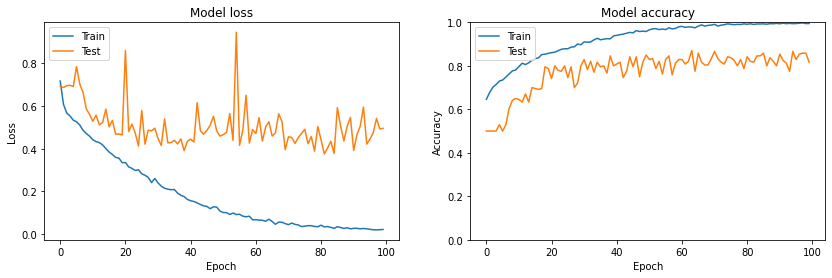

In [12]:
f = plt.figure(figsize=(14, 4))
f.add_subplot(121)
plt.plot(history_onlyCNN.history['loss'])
plt.plot(history_onlyCNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

f.add_subplot(122)
plt.plot(history_onlyCNN.history['accuracy'])
plt.plot(history_onlyCNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'], loc='upper left')

## CNN With Physical Layer: Projection Weight

In [0]:
class physical_layer1(tf.keras.layers.Layer):
    def __init__(self):
        super(physical_layer1, self).__init__()

    def build(self, input_shape):
        projection_weight = np.ones([input_shape[2], 1], np.float32)
        self.unit_matrix = np.ones([1, input_shape[1]], np.float32)
        self.W = tf.Variable(initial_value=projection_weight, trainable=True)
        #self.noise = tf.random.poisson(shape=[input_shape[1], input_shape[2]], lam=0.1)
        self.noise = tf.random.normal([256,256], stddev = 0.1)
        super(physical_layer1, self).build(input_shape)
    
    def call(self, input):
        input = (tf.cast(tf.squeeze(input, 3), tf.float32))
        weight_matrix = self.W @ self.unit_matrix
        result = tf.math.multiply(tf.transpose(weight_matrix), input)
        # result += self.noise/2
        return result[..., tf.newaxis]

In [0]:
cnn_projection_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256,256,1)),
    physical_layer1(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_projection_model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','FalsePositives','FalseNegatives'])

In [15]:
history_project = cnn_projection_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/100
68/68 [==============================] - 5s 75ms/step - loss: 0.7140 - accuracy: 0.6394 - false_positives: 382.0000 - false_negatives: 397.0000 - val_loss: 0.6929 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 2/100
68/68 [==============================] - 5s 69ms/step - loss: 0.5807 - accuracy: 0.7028 - false_positives: 311.0000 - false_negatives: 331.0000 - val_loss: 0.6964 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 3/100
68/68 [==============================] - 5s 69ms/step - loss: 0.5524 - accuracy: 0.7190 - false_positives: 277.0000 - false_negatives: 330.0000 - val_loss: 0.7069 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 4/100
68/68 [==============================] - 5s 69ms/step - loss: 0.5470 - accuracy: 0.7315 - false_positives: 239.0000 - false_negatives: 341.0000 - val_loss: 0.7429 - val_accuracy: 0.5000 - val_fals

In [64]:
print('False Positives in Validation: ' +str(history_project.history['val_false_positives']))
print('False Negatives in Validation: ' +str(history_project.history['val_false_negatives']))
FP_pro = history_project.history['val_false_positives']
FN_pro = history_project.history['val_false_negatives']

sensitivity_pro = (P-np.mean(FN_pro[30:]))/P
specificity_pro = (N-np.mean(FP_pro[30:]))/N

print(sensitivity_pro)
print(specificity_pro)

False Positives in Validation: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 24.0, 17.0, 25.0, 4.0, 24.0, 16.0, 36.0, 9.0, 26.0, 16.0, 34.0, 6.0, 29.0, 17.0, 23.0, 15.0, 25.0, 32.0, 18.0, 14.0, 37.0, 31.0, 19.0, 54.0, 16.0, 26.0, 17.0, 29.0, 11.0, 11.0, 0.0, 2.0, 8.0, 21.0, 8.0, 25.0, 12.0, 17.0, 18.0, 35.0, 17.0, 20.0, 3.0, 6.0, 43.0, 3.0, 13.0, 4.0, 14.0, 19.0, 3.0, 17.0, 3.0, 7.0, 10.0, 10.0, 5.0, 11.0, 11.0, 30.0, 16.0, 31.0, 0.0, 40.0, 3.0, 2.0, 14.0, 18.0, 15.0, 21.0, 16.0, 9.0, 4.0, 4.0, 31.0, 10.0, 12.0, 20.0, 19.0, 3.0, 18.0, 20.0, 4.0, 35.0, 13.0, 4.0, 4.0, 5.0, 3.0, 16.0, 9.0]
False Negatives in Validation: [120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 104.0, 72.0, 63.0, 63.0, 19.0, 71.0, 57.0, 61.0, 13.0, 65.0, 38.0, 60.0, 23.0, 60.0, 20.0, 49.0, 21.0, 46.0, 30.0, 22.0, 37.0, 46.0, 16.0, 21.0, 29.0, 8.0, 40.0, 29.0, 34.0, 20.0, 40.0, 39.0, 56.0, 49.0, 44.0, 27.0, 43.0, 21.0, 36.0, 25.0, 26.0, 13.0, 31.0, 24.0, 43.0, 40.0, 10.0, 42.0, 35.0, 43.0, 34.0, 23.0, 44.0, 28.0, 

In [17]:
cnn_projection_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
physical_layer1 (physical_la (None, 256, 256, 1)       256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 32)      832       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 64, 32)       

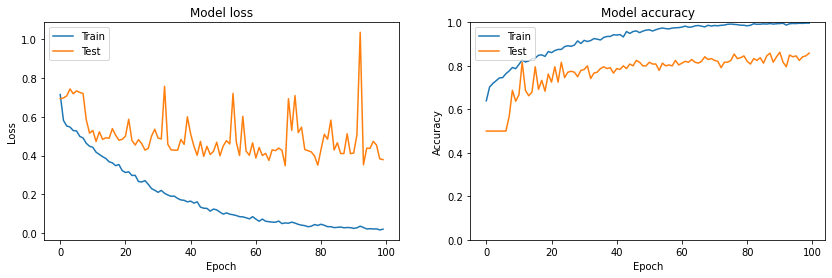

In [18]:
f = plt.figure(figsize=(14, 4))
f.add_subplot(121)
plt.plot(history_project.history['loss'])
plt.plot(history_project.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

f.add_subplot(122)
plt.plot(history_project.history['accuracy'])
plt.plot(history_project.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'], loc='upper left')

## CNN With Physical Layer: Filter in Frequency Domain

In [0]:
class physical_layer2(tf.keras.layers.Layer):
    def __init__(self):
        super(physical_layer2, self).__init__()
        #super().__init__()

    def build(self, input_shape):
        mask = np.zeros([input_shape[1], input_shape[2]], np.float32)
        for i in range(input_shape[1]):
            for j in range(input_shape[2]):
                    mask[i, j] = 0.01
        #mask = np.ones([256, 256], np.float32)
        self.W = tf.Variable(initial_value=mask, trainable=True)
        super(physical_layer2, self).build(input_shape) 
        
    def call(self, input):
        input = (tf.cast(tf.squeeze(input, 3), tf.complex64))
        mask_fft = tf.cast(self.W, tf.complex64)
        input_fft = tf.signal.fftshift(tf.signal.fft2d(input))
        result = tf.abs(tf.signal.ifft2d(tf.signal.ifftshift(input_fft * mask_fft)))
        return result[..., tf.newaxis]

In [0]:
cnn_filter_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256,256,1)),
    physical_layer2(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_filter_model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','FalsePositives','FalseNegatives'])

In [41]:
history_filter = cnn_filter_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/100
68/68 [==============================] - 5s 79ms/step - loss: 0.6177 - accuracy: 0.6431 - false_positives: 439.0000 - false_negatives: 332.0000 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 2/100
68/68 [==============================] - 5s 72ms/step - loss: 0.5675 - accuracy: 0.7102 - false_positives: 324.0000 - false_negatives: 302.0000 - val_loss: 0.6953 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 3/100
68/68 [==============================] - 5s 72ms/step - loss: 0.5274 - accuracy: 0.7361 - false_positives: 248.0000 - false_negatives: 322.0000 - val_loss: 0.6947 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 4/100
68/68 [==============================] - 5s 71ms/step - loss: 0.5021 - accuracy: 0.7556 - false_positives: 247.0000 - false_negatives: 281.0000 - val_loss: 0.6949 - val_accuracy: 0.5000 - val_fals

In [44]:
print('False Positives in Validation: ' +str(history_filter.history['val_false_positives']))
print('False Negatives in Validation: ' +str(history_filter.history['val_false_negatives']))
FP_fil = history_filter.history['val_false_positives']
FN_fil = history_filter.history['val_false_negatives']

sensitivity_fil = (P-np.mean(FN_fil[30:]))/P
specificity_fil = (N-np.mean(FP_fil[30:]))/N

print(sensitivity_fil)
print(specificity_fil)

False Positives in Validation: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.0, 19.0, 24.0, 24.0, 25.0, 24.0, 28.0, 24.0, 32.0, 33.0, 28.0, 38.0, 32.0, 35.0, 34.0, 40.0, 28.0, 36.0, 15.0, 10.0, 26.0, 30.0, 24.0, 25.0, 32.0, 30.0, 24.0, 24.0, 27.0, 19.0, 21.0, 17.0, 25.0, 25.0, 14.0, 24.0, 15.0, 17.0, 13.0, 18.0, 19.0, 11.0, 21.0, 15.0, 13.0, 8.0, 5.0, 14.0, 13.0, 13.0, 11.0, 10.0, 8.0, 12.0, 10.0, 12.0, 13.0, 8.0, 15.0, 10.0, 11.0, 10.0, 8.0, 14.0, 10.0, 10.0, 11.0, 6.0, 9.0, 11.0, 13.0, 7.0, 11.0, 11.0, 10.0, 11.0, 4.0, 6.0, 8.0, 11.0, 12.0, 11.0, 8.0, 8.0, 9.0, 8.0, 11.0, 8.0, 7.0, 6.0, 7.0]
False Negatives in Validation: [120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 104.0, 96.0, 73.0, 72.0, 72.0, 34.0, 36.0, 11.0, 26.0, 13.0, 24.0, 11.0, 1.0, 15.0, 0.0, 17.0, 4.0, 15.0, 13.0, 19.0, 4.0, 27.0, 38.0, 17.0, 7.0, 15.0, 18.0, 5.0, 14.0, 10.0, 12.0, 10.0, 14.0, 11.0, 17.0, 9.0, 10.0, 25.0, 12.0, 19.0, 17.0, 19.0, 12.0, 11.0, 23.0, 9.0, 21.0, 14.0, 29.0, 25.0, 15.0, 18.0, 17.0, 20.0, 16.0,

In [45]:
cnn_filter_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
physical_layer2_2 (physical_ (None, 256, 256, 1)       65536     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 32)      832       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 32)        25632     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 32)       

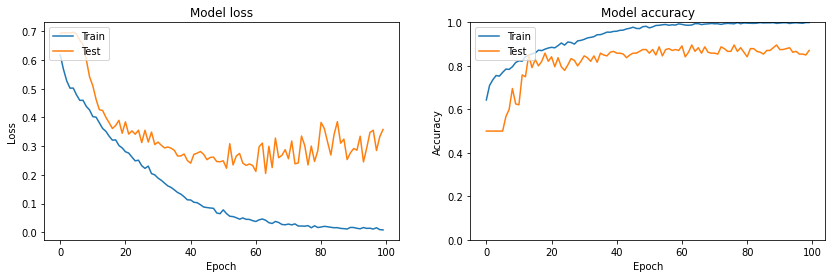

In [46]:
f = plt.figure(figsize=(14, 4))
f.add_subplot(121)
plt.plot(history_filter.history['loss'])
plt.plot(history_filter.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

f.add_subplot(122)
plt.plot(history_filter.history['accuracy'])
plt.plot(history_filter.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Test'], loc='upper left')

## CNN With Both Physical Layers: Projection Weight And Filter

In [0]:
cnn_both_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(256,256,1)),
    physical_layer1(),
    physical_layer2(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_both_model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy','FalsePositives','FalseNegatives'])

In [51]:
#history = cnn_model.fit(aug_train, epochs=15, validation_data=(x_test, y_test), shuffle=True)
history_both = cnn_both_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/100
68/68 [==============================] - 5s 79ms/step - loss: 0.6081 - accuracy: 0.6514 - false_positives: 410.0000 - false_negatives: 343.0000 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 2/100
68/68 [==============================] - 5s 74ms/step - loss: 0.5585 - accuracy: 0.7250 - false_positives: 268.0000 - false_negatives: 326.0000 - val_loss: 0.6948 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 3/100
68/68 [==============================] - 5s 74ms/step - loss: 0.5212 - accuracy: 0.7338 - false_positives: 266.0000 - false_negatives: 309.0000 - val_loss: 0.6966 - val_accuracy: 0.5000 - val_false_positives: 0.0000e+00 - val_false_negatives: 120.0000
Epoch 4/100
68/68 [==============================] - 5s 74ms/step - loss: 0.5003 - accuracy: 0.7514 - false_positives: 245.0000 - false_negatives: 292.0000 - val_loss: 0.6980 - val_accuracy: 0.5000 - val_fals

In [52]:
print('False Positives in Validation: ' +str(history_both.history['val_false_positives']))
print('False Negatives in Validation: ' +str(history_both.history['val_false_negatives']))
FP_both = history_both.history['val_false_positives']
FN_both = history_both.history['val_false_negatives']

sensitivity_both = (P-np.mean(FN_both[30:]))/P
specificity_both = (N-np.mean(FP_both[30:]))/N

print(sensitivity_both)
print(specificity_both)

False Positives in Validation: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 24.0, 24.0, 32.0, 36.0, 25.0, 17.0, 26.0, 27.0, 32.0, 19.0, 24.0, 33.0, 21.0, 20.0, 22.0, 2.0, 26.0, 29.0, 22.0, 32.0, 26.0, 19.0, 39.0, 10.0, 18.0, 29.0, 21.0, 25.0, 33.0, 26.0, 15.0, 31.0, 23.0, 6.0, 18.0, 16.0, 24.0, 8.0, 26.0, 13.0, 17.0, 9.0, 21.0, 8.0, 14.0, 17.0, 4.0, 8.0, 4.0, 18.0, 16.0, 9.0, 23.0, 12.0, 11.0, 12.0, 13.0, 9.0, 19.0, 28.0, 7.0, 1.0, 10.0, 11.0, 10.0, 12.0, 15.0, 16.0, 19.0, 11.0, 16.0, 15.0, 7.0, 12.0, 15.0, 26.0, 12.0, 8.0, 14.0, 3.0, 10.0, 10.0, 11.0, 7.0, 8.0, 18.0, 11.0, 12.0]
False Negatives in Validation: [120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 100.0, 84.0, 72.0, 72.0, 68.0, 55.0, 45.0, 11.0, 1.0, 16.0, 49.0, 25.0, 17.0, 4.0, 30.0, 30.0, 3.0, 29.0, 29.0, 26.0, 36.0, 23.0, 11.0, 23.0, 10.0, 10.0, 22.0, 0.0, 29.0, 18.0, 5.0, 13.0, 9.0, 7.0, 11.0, 22.0, 8.0, 9.0, 22.0, 14.0, 13.0, 14.0, 24.0, 8.0, 12.0, 16.0, 19.0, 13.0, 21.0, 16.0, 13.0, 28.0, 23.0, 24.0, 

In [53]:
cnn_both_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
physical_layer1_2 (physical_ (None, 256, 256, 1)       256       
_________________________________________________________________
physical_layer2_3 (physical_ (None, 256, 256, 1)       65536     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 32)      832       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)       

In [0]:
# Save the accuracy in the google drive for further analysis
#val_accuracy = history_both.history['val_accuracy'] 
#np.save("/content/drive/My Drive/MLProject/accuracy_projection/{}_{}".format('realaccuracy', '30'), val_accuracy)

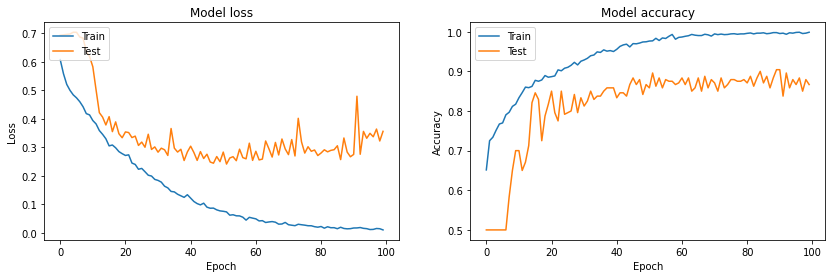

In [55]:
f = plt.figure(figsize=(14, 4))
f.add_subplot(121)
plt.plot(history_both.history['loss'])
plt.plot(history_both.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

f.add_subplot(122)
plt.plot(history_both.history['accuracy'])
plt.plot(history_both.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

## Compare Preformance of Different Physical Layers

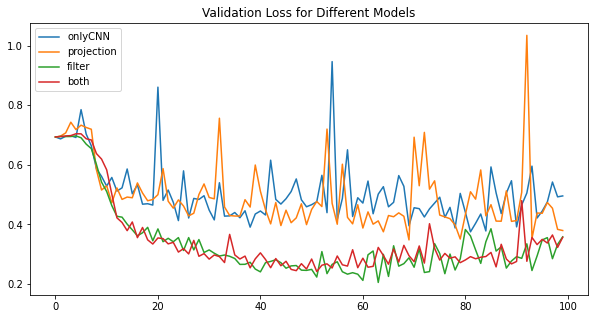

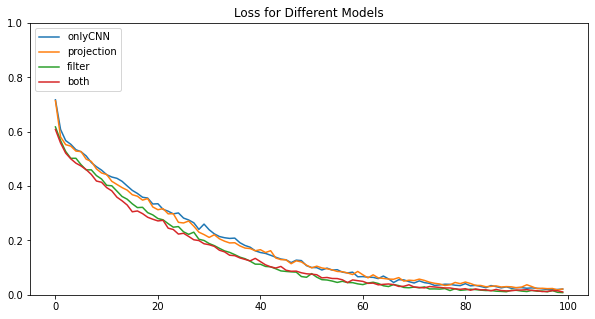

In [56]:
plt.figure(figsize = (10,5))
plt.plot(history_onlyCNN.history['val_loss'])
plt.plot(history_project.history['val_loss'])
plt.plot(history_filter.history['val_loss'])
plt.plot(history_both.history['val_loss'])
#plt.ylim([0.1,1])
plt.title('Validation Loss for Different Models')
plt.legend(['onlyCNN', 'projection', 'filter', 'both'], loc='upper left')
plt.show()

plt.figure(figsize = (10,5))
plt.plot(history_onlyCNN.history['loss'])
plt.plot(history_project.history['loss'])
plt.plot(history_filter.history['loss'])
plt.plot(history_both.history['loss'])
plt.ylim([0,1])
plt.title('Loss for Different Models')
plt.legend(['onlyCNN', 'projection', 'filter', 'both'], loc='upper left')
plt.show()


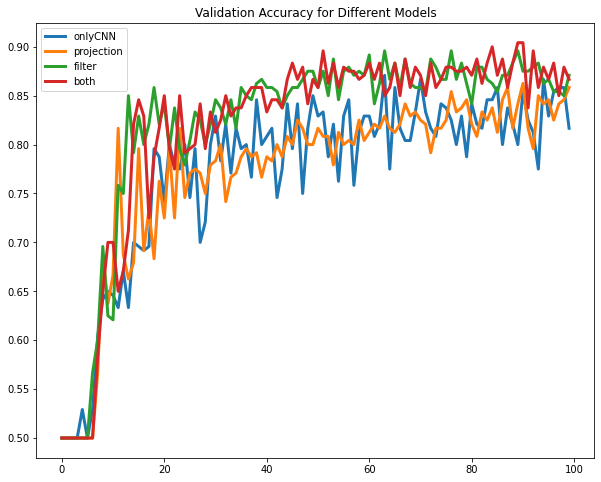

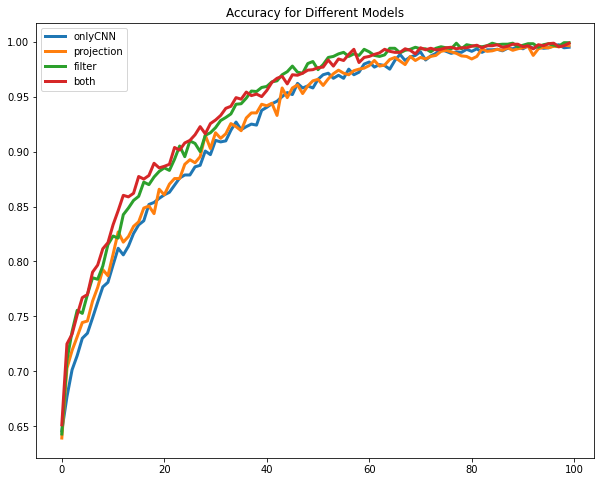

In [57]:
plt.figure(figsize = (10,8))
plt.plot(history_onlyCNN.history['val_accuracy'], linewidth=3)
plt.plot(history_project.history['val_accuracy'], linewidth=3)
plt.plot(history_filter.history['val_accuracy'], linewidth=3)
plt.plot(history_both.history['val_accuracy'], linewidth=3)
#plt.ylim([0.2,1])
plt.title('Validation Accuracy for Different Models')
plt.legend(['onlyCNN', 'projection', 'filter', 'both'], loc='upper left')
plt.show()

plt.figure(figsize = (10,8))
plt.plot(history_onlyCNN.history['accuracy'], linewidth=3)
plt.plot(history_project.history['accuracy'], linewidth=3)
plt.plot(history_filter.history['accuracy'], linewidth=3)
plt.plot(history_both.history['accuracy'], linewidth=3)
#plt.ylim([0.5,1])
plt.title('Accuracy for Different Models')
plt.legend(['onlyCNN', 'projection', 'filter', 'both'], loc='upper left')
plt.show()

In [58]:
# Print
val_acc = history_both.history['val_accuracy']
avg_val_acc = sum(val_acc)/len(val_acc)
print(avg_val_acc)

val_loss = history_both.history['val_loss']
avg_val_loss = sum(val_loss)/len(val_loss)
print(avg_val_loss)

0.8177500003576279
0.34749427646398545


In [0]:
# Save projection and filter weights in google drive for further analysis
#a = cnn_both_model.layers[0].get_weights()
#np.save("/content/drive/My Drive/MLProject/accuracy_projection/{}_{}".format('projection_w', '20'), a)

In [0]:
#b = cnn_both_model.layers[1].get_weights()
#np.save("/content/drive/My Drive/MLProject/accuracy_projection/{}_{}".format('filter_w', '20'), b)

intermediate_result has shape: (1, 256, 256, 1)
1.4984502011121228
1.4984657


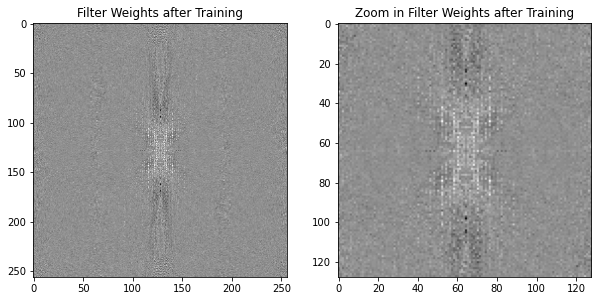

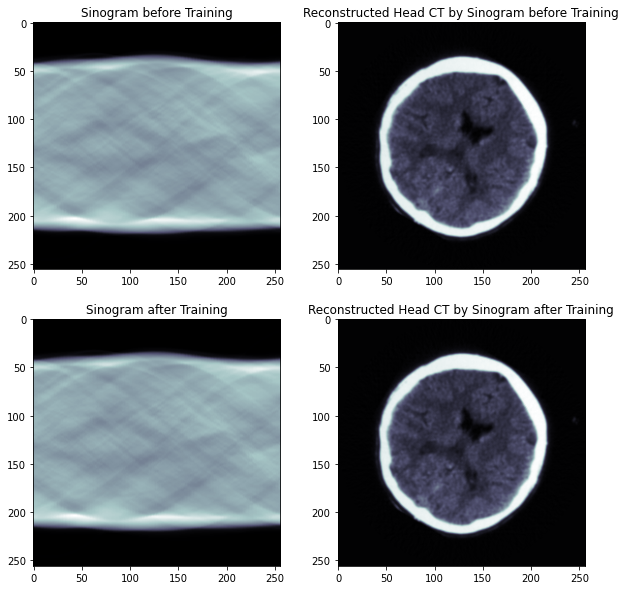

In [59]:
# Plot projection weight and filter weight
num = 155
a = cnn_both_model.layers[0].get_weights()
b = cnn_both_model.layers[1].get_weights()
#print(a)
#print(b)
w = b[0]
#print(np.max(w))
f = plt.figure(figsize= (10,5))
f.add_subplot(121)
plt.imshow(w ,cmap="gray")
plt.title('Filter Weights after Training')

f.add_subplot(122)
plt.imshow(w[64:192,64:192] ,cmap="gray")
plt.title('Zoom in Filter Weights after Training')

#-------------------------------------------------------------------------------------------------------------
cnn_both_model.layers[0]._name = 'projection_weight'
cnn_both_model.layers[1]._name = 'high_pass_filter'
layer_output=cnn_both_model.get_layer('projection_weight').output
intermediate_model=tf.keras.models.Model(inputs=cnn_both_model.input, outputs=layer_output)
intermediate_result=intermediate_model.predict(x_train[num:num+1, :, :, :])
intermediate_result.shape
print('intermediate_result has shape: {}'.format(intermediate_result.shape))
# print(x_train[num, :, :, 0])
g = plt.figure(figsize = (10,10))
g.add_subplot(221)
plt.imshow(x_train[num, :, :, 0], cmap="bone")
plt.title('Sinogram before Training')

g.add_subplot(222)
plt.imshow(iradon(x_train[num, :, :, 0]), cmap="bone")
plt.title('Reconstructed Head CT by Sinogram before Training')

# print(intermediate_result[0, :, :, 0])
g.add_subplot(223)
plt.imshow(intermediate_result[0, :, :, 0], cmap="bone")
plt.title('Sinogram after Training')

g.add_subplot(224)
plt.imshow(iradon(intermediate_result[0, :, :, 0]), cmap="bone")
plt.title('Reconstructed Head CT by Sinogram after Training')

before = x_train[num, :, :, 0]
after = intermediate_result[0, :, :, 0]

print(np.mean(before)/np.std(before))
print(np.mean(after)/np.std(after))

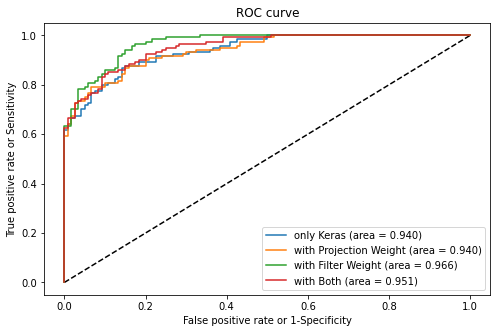

<Figure size 432x288 with 0 Axes>

In [60]:
from sklearn.metrics import roc_curve

y_pred_keras = cnn_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

y_pred_keras1 = cnn_projection_model.predict(x_test).ravel()
fpr_keras1, tpr_keras1, thresholds_keras1 = roc_curve(y_test, y_pred_keras1)

y_pred_keras2 = cnn_filter_model.predict(x_test).ravel()
fpr_keras2, tpr_keras2, thresholds_keras2 = roc_curve(y_test, y_pred_keras2)

y_pred_keras3 = cnn_both_model.predict(x_test).ravel()
fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(y_test, y_pred_keras3)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras1 = auc(fpr_keras1, tpr_keras1)
auc_keras2 = auc(fpr_keras2, tpr_keras2)
auc_keras3 = auc(fpr_keras3, tpr_keras3)

plt.figure(figsize = (8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='only Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras1, tpr_keras1, label='with Projection Weight (area = {:.3f})'.format(auc_keras1))
plt.plot(fpr_keras2, tpr_keras2, label='with Filter Weight (area = {:.3f})'.format(auc_keras2))
plt.plot(fpr_keras3, tpr_keras3, label='with Both (area = {:.3f})'.format(auc_keras3))
plt.xlabel('False positive rate or 1-Specificity')
plt.ylabel('True positive rate or Sensitivity')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.savefig("/content/drive/My Drive/MLProject/ROC_curve.png")